In [1]:
import argparse
from os import makedirs, listdir
from synapsbi.prior import RestrictedPrior as Prior
import submitit
from synapsbi.utils import save_data_to_hdf5, read_monitor_weights_files, _make_unique_samples, _forward, get_output_cluster
from synapsbi.simulator import make_param_files_cluster
import numpy as np
import yaml
import h5py
import matplotlib

import pickle
from concurrent import futures
from torch import FloatTensor as FT
import matplotlib.pyplot as plt
import torch

#### 1/ Simulation parameters, hardware options for polynomial rules

In [9]:
save_dir = "data_synapsesbi/bg_IF_EEEIIEII_6pPol/"
runs_path = "runs_synapsesbi/bg_IF_EEEIIEII_6pPol/"
task_name = "bg_IF_EEEIIEII_6pPol"
round_name = "pi3_r5to10Hz"
from synapsbi.simulator import Simulator_bg_IF_EEEIIEII_6pPol as Simulator

#For parallel execution on local computer
hardware = "local"
parallel_args = dict()
parallel_args["max_workers"]= 10 #depending on how many cpus are available

#Get simulator params and make simulator
with open("tasks_configs/%s.yaml" % task_name, "r") as f:
    simulator_params = yaml.load(f, Loader=yaml.Loader)
simulator = Simulator(simulator_params)

#### 1 bis/ Simulation parameters, hardware options for MLP rules

In [8]:
save_dir = "data_synapsesbi/bg_CVAIF_EEIE_T4wvceciMLP/"
runs_path = "runs_synapsesbi/bg_CVAIF_EEIE_T4wvceciMLP/"
task_name = "bg_CVAIF_EEIE_T4wvceciMLP"
round_name = "pi3_r5to10Hz"
from synapsbi.simulator import Simulator_bg_CVAIF_EEIE_T4wvceciMLP as Simulator

#For parallel execution on local computer
hardware = "local"
parallel_args = dict()
parallel_args["max_workers"]= 10 #depending on how many cpus are available

#Get simulator params and make simulator
with open("tasks_configs/%s.yaml" % task_name, "r") as f:
    simulator_params = yaml.load(f, Loader=yaml.Loader)
simulator = Simulator(simulator_params)

#### Use samples generated in previous notebook

In [10]:
thetas = np.load(save_dir + "post_samples_" + round_name + ".npz")["thetas"]
num_samples = len(thetas)

thetas, seeds = _make_unique_samples(num_samples, 
                                     prior=None,
                                     thetas=thetas,
                                     saved_seeds=[])

#### Simulate the samples

Refer to readme to make sure the spiking network simulator Auryn is installed on your machine

In [11]:
### prepare thetas for the simulation
parameters = [dict(simulator=simulator,
                   thetas=th.reshape(1, -1),
                   seeds=[seed],
                   return_data=False)
              for th, seed in zip(thetas, seeds)][:num_samples]

(10, 1, 25)


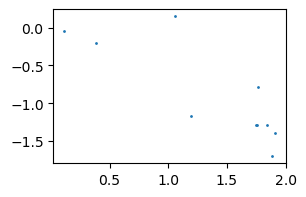

In [12]:
## Quick look at the samples
try:
    a = np.array([i['thetas'].numpy() for i in parameters])
except:
    a = np.array([i['thetas'] for i in parameters])
print(a.shape)

fig = plt.figure(figsize=(3, 2)), plt.scatter(a[:,0,2],a[:,0,3], s = 1); plt.show()

In [14]:
## Collect the results
outputs = []
for job in jobs:
    outputs.append(job.result())
#     print(job.result())

#### Store simulations

In [15]:
print("fraction of blown up simulations:", sum(np.array(outputs) > 0) / len(outputs))

fraction of blown up simulations: 0.0


In [16]:
save_data_to_hdf5(save_dir + round_name + ".h5",
                  thetas=thetas,
                  seeds=seeds,
                  spiketimes_workdir=simulator_params["workdir"],
                  con_type=simulator_params["con_type"],
                  outputs=outputs,
                  params=simulator_params)

0it [00:00, ?it/s]

Do you want to remove all auryn monitor files? (y/n):y
deleting all monitor files


()

Congratulations, you have now simulated your rules in spiking networks and stored the raw weight traces and spike trains.
Now head over to Compute_metrics to compute start the analysis of your simulations

##### Bonus: initial round (if you want to refilter rules from scratch)

###### If round 0: draw samples from prior, WITHOUT classifier

In [ ]:
### POLY
# prior_cls = "_Prior_bg_IF_EEEIIEII_6pPol"
# prior_cls_args = dict(lower_lim=[0.01, 0.01, -2., -2., -2., -2.,
#                          0.01, 0.01, -2., -2., -2., -2.,
#                          0.01, 0.01, -2., -2., -2., -2.,
#                          0.01, 0.01, -2., -2., -2., -2.,
#                          5],
#               upper_lim=[.1, .1, 2., 2., 2., 2.,
#                          .1, .1, 2., 2., 2., 2.,
#                          .1, .1, 2., 2., 2., 2.,
#                          .1, .1, 2., 2., 2., 2.,
#                          15]
#                      )

## MLP
# prior_cls = "_Prior_bg_CVAIF_EEIE_T4wvceciMLP"
# prior_cls_args = dict(lower_lim=[0., 0., -1., -1., -1., -1., #etaEE, etaIE, WpreEE, WpostEE, WpreIE, WpostIE
#                 -1., -1., -1., -1., -1., -1.,
#                 -1., -1., -1., -1., -1., -1.,
#                 -1., -1., -1., -1., 5],
#     upper_lim= [1., 1., 1., 1., 1., 1., #etaEE, etaIE, WpreEE, WpostEE, WpreIE, WpostIE
#                 1., 1., 1., 1., 1., 1.,
#                 1., 1., 1., 1., 1., 1.,
#                 1., 1., 1., 1., 15])



prior = Prior(prior_class=prior_cls,
              prior_class_args=prior_cls_args,
              return_numpy=False,
              restrict_prior=False,
              )

num_samples = 10
thetas, seeds = _make_unique_samples((num_samples,),
                                     prior=prior,
                                     saved_seeds=[])

###### If round 0+: draw samples from prior + classifier

We train a classifier on the training set to accept or reject new samples (for sample efficiency),
this is introduced and explained in ______________

In [ ]:
## load training data for classifier

## POLY
# metrics_for_classifier = np.load(save_dir + "box_prior_metrics.npy")

## MLP
# metrics_for_classifier = np.load(save_dir + "box_prior_metrics.npy")


theta_classifier, x_classifier = FT(metrics_for_classifier['theta']), FT(metrics_for_classifier['rate'])
sum(~torch.isfinite(x_classifier)) / len(x_classifier)